# Feature Engineering for xG-NextGen Project

This notebook engineers advanced features from cleaned soccer shot data to improve xG modeling.

## Import Libraries

Load required Python packages and modules.

In [ ]:
!pip install pandas numpy xgboost scikit-learn shap matplotlib

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import os

## Load Cleaned Data

Import processed shots and freeze frame data.

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Change directory to your project folder inside Drive
import os

project_path = "/content/drive/MyDrive/xG-NextGen"
os.chdir(project_path)

print("Current working directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/xG-NextGen


## Time-Based Feature

Extract minute of match from timestamp.

In [ ]:
print("Engineering time-based features...")

# Convert timestamp to datetime
shots_df['timestamp'] = pd.to_datetime(shots_df['timestamp'])

# Extract minute of match
shots_df['minute'] = shots_df['timestamp'].dt.hour * 60 + \
                     shots_df['timestamp'].dt.minute + \
                     shots_df['timestamp'].dt.second / 60

# Drop original timestamp
shots_df = shots_df.drop('timestamp', axis=1)

Engineering time-based features...


## Geometric Features

Calculate shot distance and angle relative to goal.

In [ ]:
print("Calculating geometric features...")
GOAL_CENTER = (120, 40)
GOAL_WIDTH  = 7.32

def compute_distance(x, y):
    return np.sqrt((x - GOAL_CENTER[0])**2 + (y - GOAL_CENTER[1])**2)

shots_df['distance'] = shots_df.apply(lambda r: compute_distance(r['x'], r['y']), axis=1)

def calculate_angle(row):
    x, y = row['x'], row['y']
    left_post  = (GOAL_CENTER[0], GOAL_CENTER[1] - GOAL_WIDTH/2)
    right_post = (GOAL_CENTER[0], GOAL_CENTER[1] + GOAL_WIDTH/2)

    a = np.sqrt((x - right_post[0])**2 + (y - right_post[1])**2)
    b = np.sqrt((x - left_post[0])**2 + (y - left_post[1])**2)
    c = GOAL_WIDTH

    # Calculate raw cosine
    if a > 0 and b > 0:
        cos_val = (a*a + b*b - c*c) / (2 * a * b)
    else:
        cos_val = 0
    # Clamp to valid domain
    cos_val = np.clip(cos_val, -1.0, 1.0)

    # Compute angle
    angle_rad = np.arccos(cos_val)
    return np.degrees(angle_rad)

shots_df['angle'] = shots_df.apply(calculate_angle, axis=1)
# Clean up any potential NaNs or negatives
shots_df['angle'] = shots_df['angle'].fillna(0)
shots_df.loc[shots_df['angle'] < 0, 'angle'] = 0

Calculating geometric features...


## Defensive Pressure Features

Compute defensive pressure metrics from freeze frame data.

In [ ]:
print("Calculating defensive pressure features (vectorized)…")
import numpy as np

# 1. Reload shot locations with renamed columns
loc_df = pd.read_csv(
    os.path.join(processed_dir, 'shots.csv'),
    usecols=['shot_id', 'x', 'y']
)

# 2. Merge freeze frames to shot locations (add suffixes!)
merged_df = freeze_df.merge(
    loc_df,
    on='shot_id',
    suffixes=('_player', '_shot')
)

# 3. Compute distances from player to shot
merged_df['dist'] = np.hypot(
    merged_df['x_player'] - merged_df['x_shot'],
    merged_df['y_player'] - merged_df['y_shot']
)

# 4. Identify defenders and goalkeepers
is_defender = (~merged_df['teammate']) & (~merged_df['goalkeeper'])
is_keeper   = (~merged_df['teammate']) & ( merged_df['goalkeeper'])

# 5. Count defenders within 5 meters
defs_within_5m = merged_df[is_defender & (merged_df['dist'] <= 5)]
defender_counts = defs_within_5m.groupby('shot_id').size()

# 6. Find min distance to goalkeeper
gks = merged_df[is_keeper]
gk_min_dist = gks.groupby('shot_id')['dist'].min()

# 7. Map results back to main DataFrame
shots_df['defenders_in_5m'] = shots_df['shot_id'].map(defender_counts).fillna(0).astype(int)
shots_df['gk_distance'] = shots_df['shot_id'].map(gk_min_dist).fillna(50.0)

print("Done — vectorized defensive pressure features created.")

Calculating defensive pressure features (vectorized)…
Done — vectorized defensive pressure features created.


## Angular Defensive Pressure Features

In [ ]:
print("Calculating angular defensive pressure (vectorized)…")
import numpy as np

# 1) Rebuild merged_df: join every freeze‐frame point to its shot x/y
merged_df = freeze_df.merge(
    shots_df[['shot_id','x','y']],
    on='shot_id',
    suffixes=('_player','_shot')
)

# Compute defender–shooter deltas and distances
merged_df['dx']   = merged_df['x_player'] - merged_df['x_shot']
merged_df['dy']   = merged_df['y_player'] - merged_df['y_shot']
merged_df['dist'] = np.hypot(merged_df['dx'], merged_df['dy'])

# Filter only opponent non-GKs within 5m
mask = (
    (~merged_df['teammate']) &
    (~merged_df['goalkeeper']) &
    (merged_df['dist'] > 0) &
    (merged_df['dist'] <= 5)
)
df_def = merged_df[mask].copy()

# Compute shot→goal and defender→shooter angles
df_def['goal_ang'] = np.arctan2(40 - df_def['y_shot'], 120 - df_def['x_shot'])
df_def['def_ang']  = np.arctan2(df_def['dy'], df_def['dx'])

# Compute minimal angular difference (deg)
df_def['ang_diff'] = np.abs(np.degrees(df_def['def_ang'] - df_def['goal_ang']))
df_def['ang_diff'] = np.where(df_def['ang_diff'] > 180,
                              360 - df_def['ang_diff'],
                              df_def['ang_diff'])

# Keep defenders within ±20°
df_def = df_def[df_def['ang_diff'] <= 20]

# Weight by exp(-distance)
df_def['pressure_contrib'] = np.exp(-df_def['dist'])

# 2) Aggregate per shot
pressure_series = df_def.groupby('shot_id')['pressure_contrib'].sum()

# 3) Map back onto shots_df
shots_df['angular_pressure'] = shots_df['shot_id'].map(pressure_series).fillna(0.0)

print("Done—angular_pressure added.")

Calculating angular defensive pressure (vectorized)…
Done—angular_pressure added.


## Assist Type Encoding

In [ ]:
print("One-hot encoding assist types…")
shots_df['assist_type'] = shots_df['assist_type'].fillna('None')
assist_dums = pd.get_dummies(shots_df['assist_type'], prefix='assist', drop_first=True)
shots_df = pd.concat([shots_df,assist_dums],axis=1)
shots_df.drop('assist_type',axis=1,inplace=True)

One-hot encoding assist types…


## Pre-Shot Sequence

In [ ]:
print("Pre-shot sequence (n_prev_passes) already numeric—no transform needed.")

Pre-shot sequence (n_prev_passes) already numeric—no transform needed.


## Categorical Feature Encoding

Encode categorical variables using one-hot encoding.

In [ ]:
print("Encoding categorical features...")

# List of categorical columns to encode
cat_cols = ['body_part', 'shot_type', 'position']

# One-hot encode each categorical column
for col in cat_cols:
    # Handle missing values
    shots_df[col] = shots_df[col].fillna('Unknown')

    # One-hot encode
    dummies = pd.get_dummies(shots_df[col], prefix=col, drop_first=True)
    shots_df = pd.concat([shots_df, dummies], axis=1)

# Drop original categorical columns
shots_df = shots_df.drop(cat_cols, axis=1)

Encoding categorical features...


## Contextual Features

Incorporate match context features.

In [ ]:
print("Adding contextual features...")

# Convert boolean to int
shots_df['is_home'] = shots_df['is_home'].astype(int)

# Create goal difference absolute value
shots_df['abs_goal_diff'] = abs(shots_df['goal_difference'])

# Drop original coordinates
shots_df = shots_df.drop(['x', 'y'], axis=1)

Adding contextual features...


## Final Feature Set

Prepare and save final feature set.

In [ ]:
print("Saving final feature set...")

# Define feature columns (exclude IDs and target)
feature_cols = [col for col in shots_df.columns
                if col not in ['shot_id','match_id','shot_outcome','goal','freeze_frame']]

# Create features DataFrame
features_df = shots_df[feature_cols]

# Add target variable
features_df['goal'] = shots_df['goal']

# Save to CSV
features_path = os.path.join(processed_dir, 'features.csv')
features_df.to_csv(features_path, index=False)

print(f"Saved engineered features to {features_path}")
print(f"Final feature set shape: {features_df.shape}")

Saving final feature set...


/tmp/ipython-input-19-3647895527.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['goal'] = shots_df['goal']


Saved engineered features to /content/drive/MyDrive/xG-NextGen/data/processed/features.csv
Final feature set shape: (87111, 18)


# Collinearity Checks

We engineered X features. Before modeling, we checked for multicollinearity so as to avoid redundant variables and assess which variables influence each other most.

Loaded features: (87111, 18)
Numeric feature subset: (87111, 11)


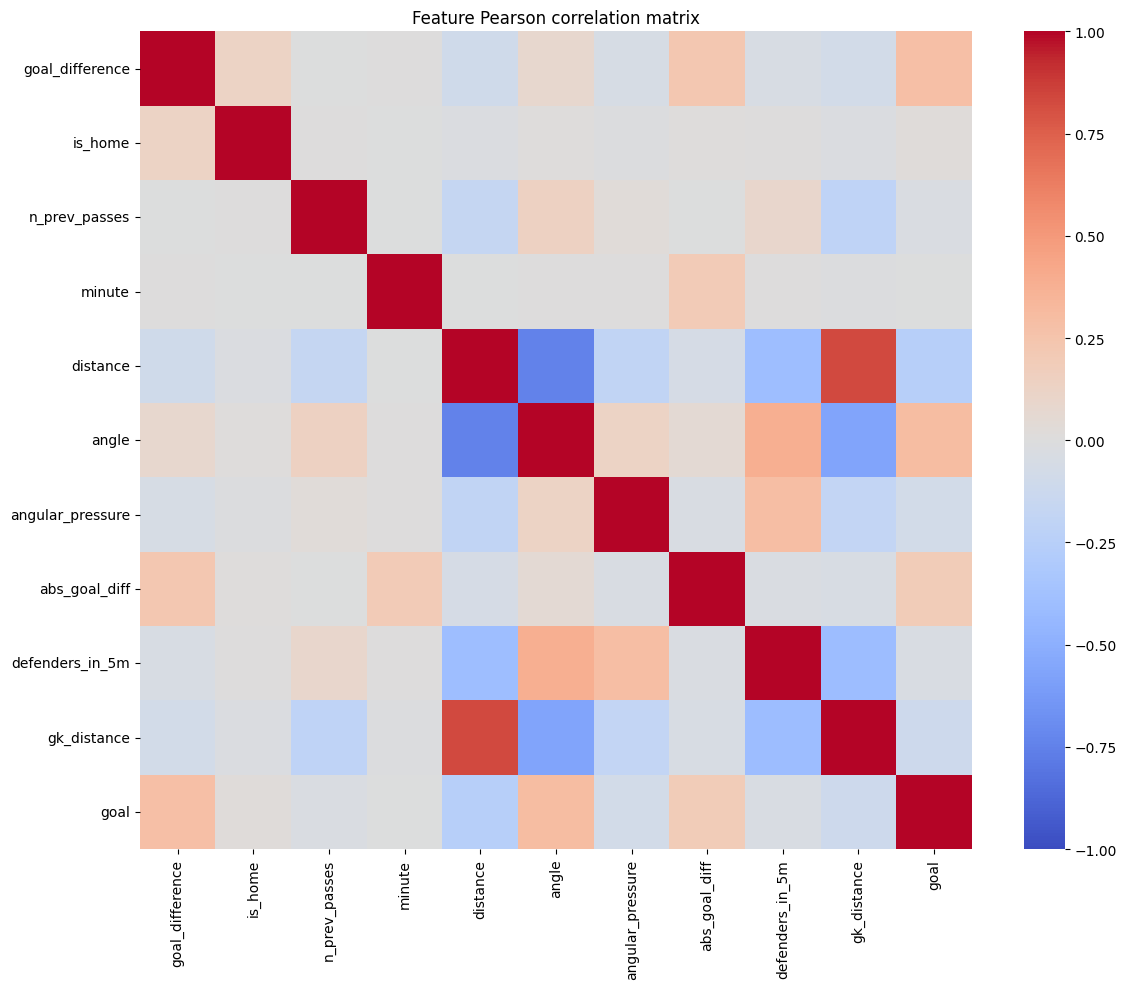

Top correlated feature pairs (|r| > 0.3):
distance  <->  gk_distance   r = 0.834
distance  <->  angle   r = -0.743
angle  <->  gk_distance   r = -0.568
defenders_in_5m  <->  gk_distance   r = -0.411
distance  <->  defenders_in_5m   r = -0.403
angle  <->  defenders_in_5m   r = 0.386


,feature,VIF
4,distance,18.587477
9,gk_distance,14.172817
5,angle,4.685356
3,minute,4.050100
8,defenders_in_5m,3.547378
2,n_prev_passes,3.350197
1,is_home,2.138109
7,abs_goal_diff,1.898297
10,goal,1.432766
6,angular_pressure,1.312485


,median_n_prev_passes,median_distance
goal_difference,,
-11,0.0,12.000000
-10,0.0,12.653063
-9,0.0,24.920072
-8,1.0,28.727791
-7,1.0,21.963265
-6,1.0,20.134051
-5,1.0,22.848414
-4,1.0,20.838666
-3,1.0,19.886176


Loaded saved XGBoost model.
Baseline AUC: 0.8775875796577203
Computing permutation importance (may take a while)…


,feature,perm_mean_auc_drop,perm_std
0,goal_difference,0.140751,0.002942
5,angle,0.102908,0.003540
9,gk_distance,0.037388,0.002002
4,distance,0.032112,0.001593
6,angular_pressure,0.012096,0.001218
3,minute,0.007082,0.001561
8,defenders_in_5m,0.006537,0.000836
2,n_prev_passes,0.002080,0.000591
7,abs_goal_diff,0.000358,0.000360
1,is_home,-0.000357,0.000267


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:14:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC after residualising n_prev_passes: 0.8781231286843938 ΔAUC: 0.0005355490266735208


 99%|===================| 17281/17423 [01:11<00:00]       

,feature,mean_abs_shap_orig,mean_abs_shap_resid
0,goal_difference,1.048836,1.071903
5,angle,0.821283,0.957277
6,angular_pressure,0.321809,0.335908
9,gk_distance,0.317663,0.314334
4,distance,0.293770,0.293395
3,minute,0.211329,0.224776
8,defenders_in_5m,0.170816,0.171711
2,n_prev_passes,0.084427,0.097816
1,is_home,0.066537,0.062315
7,abs_goal_diff,0.043283,0.059001


Diagnostics complete. Outputs written to: /content/drive/MyDrive/xG-NextGen/outputs/diagnostics


In [4]:
# Diagnostics & robustness pipeline for collinearity
# Run in Colab where you have /content/drive mounted and features.csv available.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths - adjust if necessary
processed_dir = '/content/drive/MyDrive/xG-NextGen/data/processed'
features_path = os.path.join(processed_dir, 'features.csv')
out_dir = '/content/drive/MyDrive/xG-NextGen/outputs/diagnostics'
os.makedirs(out_dir, exist_ok=True)

# Load features
df = pd.read_csv(features_path)
print("Loaded features:", df.shape)

# Drop non-numeric identifiers if present
drop_cols = [c for c in ['shot_id','match_id','shot_outcome','freeze_frame'] if c in df.columns]
numeric_df = df.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number]).copy()
print("Numeric feature subset:", numeric_df.shape)

# 1) Correlation matrix + heatmap
corr = numeric_df.corr()
corr.to_csv(os.path.join(out_dir, 'feature_correlation_matrix.csv'))
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Feature Pearson correlation matrix')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'feature_correlation_heatmap.png'), dpi=200)
plt.show()

# Print top correlated pairs
corr_abs = corr.abs()
np.fill_diagonal(corr_abs.values, 0)
# Get pairs above thresholds
pairs = []
cols = corr_abs.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr_abs.iloc[i,j]
        if val > 0.3:  # show any >0.3 for inspection
            pairs.append((cols[i], cols[j], corr.iloc[i,j]))
pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print("Top correlated feature pairs (|r| > 0.3):")
for a,b,v in pairs[:30]:
    print(f"{a}  <->  {b}   r = {v:.3f}")

# 2) VIF calculation
!pip install statsmodels --quiet
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = numeric_df.fillna(0).copy()
# remove constant columns
X_vif = X_vif.loc[:, X_vif.std() > 0]
vif_data = pd.DataFrame({'feature': X_vif.columns,
                         'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]})
vif_data = vif_data.sort_values('VIF', ascending=False)
vif_data.to_csv(os.path.join(out_dir, 'feature_vif.csv'), index=False)
display(vif_data.head(30))

# 3) conditional summaries: relationship of reviewer examples
if 'goal_difference' in df.columns:
    cond = df.groupby('goal_difference')[['n_prev_passes','distance']].median().rename(columns={'n_prev_passes':'median_n_prev_passes','distance':'median_distance'})
    cond.to_csv(os.path.join(out_dir, 'conditional_summary_by_goal_difference.csv'))
    display(cond.head(15))
else:
    print("goal_difference not present in features.csv")

# 4) Permutation importance (if you have model & X_test/y_test)
# Tries to load model; if not found, trains a simple XGBoost quickly.
model_path = '/content/drive/MyDrive/xG-NextGen/models/xgboost_model.json'
have_model = os.path.exists(model_path)
try:
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score
    from sklearn.inspection import permutation_importance
    # Prepare data
    if 'goal' in df.columns:
        y = df['goal']
        X = df.drop(columns=['goal'] + drop_cols, errors='ignore')
    else:
        raise ValueError("No 'goal' column found in features.csv for supervised diagnostics.")
    X = X.select_dtypes(include=[np.number]).fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    if have_model:
        model = xgb.XGBClassifier()
        model.load_model(model_path)
        print("Loaded saved XGBoost model.")
    else:
        print("No saved model found, training baseline XGBoost for diagnostics (fast).")
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=100, max_depth=6)
        model.fit(X_train, y_train)
    # Baseline AUC
    baseline_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print("Baseline AUC:", baseline_auc)
    # Permutation importance
    print("Computing permutation importance (may take a while)…")
    r = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1, scoring='roc_auc')
    perm_df = pd.DataFrame({'feature': X_test.columns, 'perm_mean_auc_drop': r.importances_mean, 'perm_std': r.importances_std}).sort_values('perm_mean_auc_drop', ascending=False)
    perm_df.to_csv(os.path.join(out_dir, 'permutation_importance_auc.csv'), index=False)
    display(perm_df.head(20))
except Exception as e:
    print("Permutation importance block skipped or error:", e)

# 5) Residualisation example: regress n_prev_passes on goal_difference (if present), use residuals
if 'n_prev_passes' in df.columns and 'goal_difference' in df.columns:
    from sklearn.linear_model import LinearRegression
    Xr = df[['goal_difference']].fillna(0).values.reshape(-1,1)
    yr = df['n_prev_passes'].fillna(0).values.reshape(-1,1)
    reg = LinearRegression().fit(Xr, yr.ravel())
    resid = yr.ravel() - reg.predict(Xr)
    df['n_prev_passes_resid'] = resid
    # Save residual sample statistics
    df[['n_prev_passes','n_prev_passes_resid','goal_difference']].sample(5)
    # Refit model with residualised variable (replace n_prev_passes with resid)
    X2 = X.copy()
    X2['n_prev_passes'] = df['n_prev_passes_resid']
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42, stratify=y)
    model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=100, max_depth=6)
    model2.fit(X_train2, y_train2)
    auc2 = roc_auc_score(y_test2, model2.predict_proba(X_test2)[:,1])
    print("AUC after residualising n_prev_passes:", auc2, "ΔAUC:", auc2 - baseline_auc)
    # If you compute SHAP for both, compare mean-abs SHAP sums (optional, heavy)
    try:
        import shap
        expl1 = shap.Explainer(model, X_train)
        shap1 = expl1(X_test)
        mean_abs1 = np.abs(shap1.values).mean(axis=0)
        expl2 = shap.Explainer(model2, X_train2)
        shap2 = expl2(X_test2)
        mean_abs2 = np.abs(shap2.values).mean(axis=0)
        # align and compare top features
        df_shap1 = pd.DataFrame({'feature': X_test.columns, 'mean_abs_shap': mean_abs1})
        df_shap2 = pd.DataFrame({'feature': X_test2.columns, 'mean_abs_shap': mean_abs2})
        df_shap = df_shap1.merge(df_shap2, on='feature', suffixes=('_orig','_resid')).sort_values('mean_abs_shap_orig', ascending=False)
        df_shap.to_csv(os.path.join(out_dir, 'shap_compare_orig_vs_resid.csv'), index=False)
        display(df_shap.head(20))
    except Exception as e:
        print("SHAP comparison skipped or error:", e)
else:
    print("Residualisation not run: n_prev_passes or goal_difference not present.")

print("Diagnostics complete. Outputs written to:", out_dir)


## Feature Summary

Display summary of engineered features.

In [ ]:
print("\nEngineered features summary:")
print(features_df.info())

print("\nNumerical features summary:")
print(features_df.describe())

print("\nTarget distribution:")
print(features_df['goal'].value_counts(normalize=True))


Engineered features summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87111 entries, 0 to 87110
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   goal_difference       87111 non-null  int64  
 1   is_home               87111 non-null  int64  
 2   n_prev_passes         87111 non-null  int64  
 3   minute                87111 non-null  float64
 4   distance              87111 non-null  float64
 5   angle                 87111 non-null  float64
 6   angular_pressure      87111 non-null  float64
 7   body_part_Left Foot   87111 non-null  bool   
 8   body_part_Other       87111 non-null  bool   
 9   body_part_Right Foot  87111 non-null  bool   
 10  shot_type_Free Kick   87111 non-null  bool   
 11  shot_type_Kick Off    87111 non-null  bool   
 12  shot_type_Open Play   87111 non-null  bool   
 13  shot_type_Penalty     87111 non-null  bool   
 14  abs_goal_diff         87111 non-null  in